# Barometric Presure Time Series Evaluation for 2020 Tuolumne Hydroclimate Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [ ]:
# only if using Colab and google drive for processing and data access
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


In [ ]:
working_dir = '~/Documents/MountainHydrology/HydroclimateDataPostprocessing/tum_2020/'
file_path = working_dir + 'tum_2020_raw_data/Conness_Creek_Baro_20200811.csv'
sitename = 'Conness Creek'
year = '19/20'

### Load Barologger Raw Data

In [ ]:
baro_df = pd.read_csv(file_path, header=9, index_col=0, parse_dates=[[0,1]], infer_datetime_format=True, keep_date_col=True)
baro_df

,Date,Time,ms,BAROMETRIC PRESSURE,TEMPERATURE
Date_Time,,,,,
2019-08-14 20:43:12,8/14/2019,08:43:12 pm,0,74.7207,27.699
2019-08-14 21:13:12,8/14/2019,09:13:12 pm,0,74.7446,27.986
2019-08-14 21:43:12,8/14/2019,09:43:12 pm,0,75.0084,27.847
2019-08-14 22:13:12,8/14/2019,10:13:12 pm,0,74.9063,35.165
2019-08-14 22:43:12,8/14/2019,10:43:12 pm,0,75.4546,30.329
...,...,...,...,...,...
2020-08-12 20:13:12,8/12/2020,08:13:12 pm,0,74.4318,16.528
2020-08-12 20:43:12,8/12/2020,08:43:12 pm,0,74.4320,17.504
2020-08-12 21:13:12,8/12/2020,09:13:12 pm,0,74.4343,18.379


Text(0.5, 1.0, 'Raw Barometric Pressure from Conness Creek 19/20')

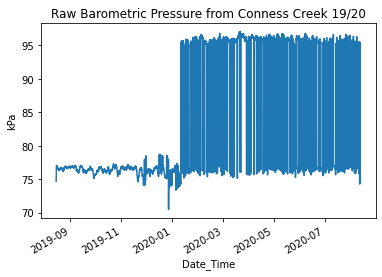

In [ ]:
baro_df['BAROMETRIC PRESSURE'].plot(ylabel='kPa')
plt.title('Raw Barometric Pressure from ' + sitename + ' ' + year)

The barologger appears to be malfunctioning. In particular, starting around 2020-02, half of the data is offset. 

### Attempt to Correct Time Series

Compute Average Difference Between Adjacent Values With Discrepancy

Approach: find the average difference between any large jump in the data, and then subtract the average distance from any value exceeding a certain threshold (some arbitrary value selected such that all of the offset data is above it). 

In [ ]:
# Constants used to distinguish correct data from offset data.
# If adjacent data points differ by at least the threshold,
# then the larger of the two is considered an offset point 
# and the difference is included in the average. 
# Visually Inspected Data to Determine Ranges (About 20).
DELTA_Y_THRESHOLD = 15 

# Introduced because one offset point was not greater than 15.
# Single Data Point with Difference of About 10 (1/11/2020 4:13 AM)
DELTA_Y_OUTLIER_MIN = 5  

In [ ]:
num_changes = 0
total_change = 0
dif_exc = 0
for i in range(baro_df['BAROMETRIC PRESSURE'].size - 1):
  dif = abs(baro_df['BAROMETRIC PRESSURE'][i] - baro_df['BAROMETRIC PRESSURE'][i+1])
  if dif > DELTA_Y_THRESHOLD:
    num_changes += 1
    total_change += dif
  if dif > DELTA_Y_OUTLIER_MIN and dif < DELTA_Y_THRESHOLD:
    dif_exc = dif
avg_dif = total_change / num_changes
print('Num Changes: ' + str(num_changes))
print('Average difference: ' + str(avg_dif))
print('Difference of Outlier: ' + str(dif_exc))

Num Changes: 303
Average difference: 19.46501188118812
Difference of Outlier: 10.738199999999992


Correct Faulty Values With Constant Offset Found Above

In [ ]:
baro_df.loc[baro_df['BAROMETRIC PRESSURE'] > 85, 'BAROMETRIC PRESSURE'] -= avg_dif
baro_df.loc[baro_df['BAROMETRIC PRESSURE'] > 80, 'BAROMETRIC PRESSURE'] -= dif_exc

Text(0.5, 1.0, 'Corrected Raw Barometric Pressure from Conness Creek 19/20')

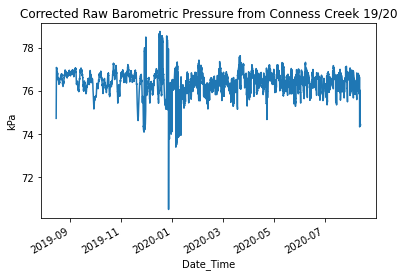

In [ ]:
baro_df['BAROMETRIC PRESSURE'].plot(ylabel='kPa')
plt.title('Corrected Raw Barometric Pressure from ' + sitename + ' ' + year)

The data looks plausible now. However, the second half of the series looks some what suspect. We will need to proceed as usual and apply the baro correction to see if the results are as expected. 

### Convert from kPa to cm h20

Text(0.5, 1.0, 'Barometric Pressure Data for Conness Creek 19/20')

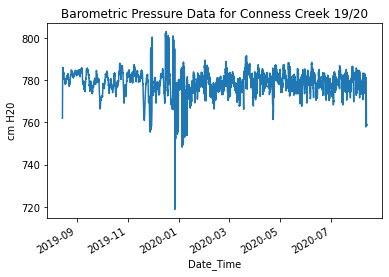

In [ ]:
KPA_TO_CM = 10.197
baro_df['BAROMETRIC PRESSURE'] *= KPA_TO_CM

baro_df['BAROMETRIC PRESSURE'].plot(ylabel='cm H20')
plt.title('Barometric Pressure Data for ' + sitename + ' ' + year)

### Trim Data

Find the start time.

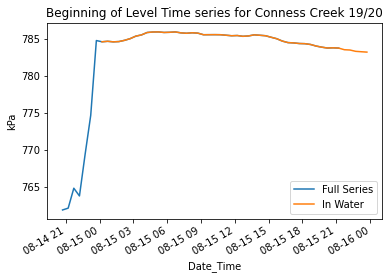

In [ ]:
# tune 'insert_datetime' to get desired time
# alternatively, refer to field notes (sometimes wrong)
insert_datetime = datetime.datetime.strptime('2019-8-15 0:00', '%Y-%m-%d %H:%M')

baro_df['BAROMETRIC PRESSURE'].head(50).plot(ylabel='kPa', label='Full Series')
baro_df['BAROMETRIC PRESSURE'][insert_datetime:insert_datetime + datetime.timedelta(days=1)].plot(label='In Water')
plt.title('Beginning of Level Time series for ' + sitename + ' ' + year)
plt.legend()

Find the end time.

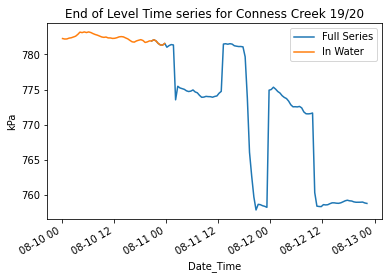

In [ ]:
# tune 'remove_datetime' to get desired time
# alternatively, refer to field notes (sometimes wrong)
remove_datetime = datetime.datetime.strptime('2020-8-11 0:00', '%Y-%m-%d %H:%M')

baro_df['BAROMETRIC PRESSURE'].tail(100).plot(ylabel='kPa', label='Full Series')
baro_df['BAROMETRIC PRESSURE'][remove_datetime - datetime.timedelta(days=1): remove_datetime:].plot(label='In Water')
plt.title('End of Level Time series for ' + sitename + ' ' + year)
plt.legend()

Trim

In [ ]:
mask = (baro_df.index >= insert_datetime) & (baro_df.index <= remove_datetime)
baro_df_trim = baro_df.loc[mask]

Verify Result

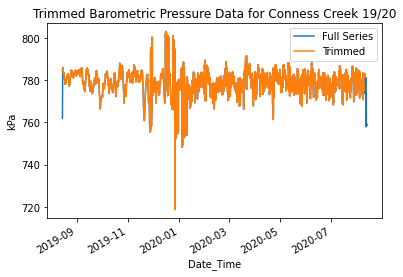

In [ ]:
baro_df['BAROMETRIC PRESSURE'].plot(ylabel='kPa', label='Full Series')
baro_df_trim['BAROMETRIC PRESSURE'].plot(label='Trimmed')
plt.title('Trimmed Barometric Pressure Data for ' + sitename + ' ' + year)
plt.legend()

In [ ]:
baro_df = baro_df_trim

### Inspect Time Zone of the Baro Data

Date times should be UTC. Inspect small period of time to make sure timing temperature peaks is as expected. 

Text(0.5, 1.0, 'Conness Creek 19/20 Barologger Temperature During Small Window')

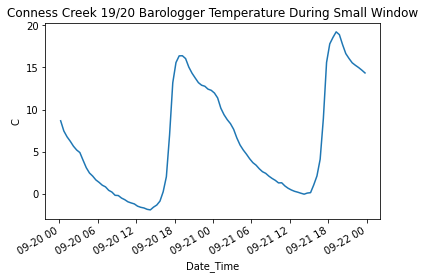

In [ ]:
start_date = '2019-09-20'
end_date = '2019-09-21'
baro_df['TEMPERATURE'][start_date:end_date].plot(ylabel='C')
plt.title(sitename + ' ' + year + ' Barologger Temperature During Small Window')

*   Max temperature occurs around 21:00 (14:00 + 7)
*   Min temperature occurs around 14:00 (7:00 + 7)

These results suggest the barologger is recording in UTC, as expected.

### Extend Time Series (join with adjacent years) as Needed

N/A

### Save the Corrected Raw Baro Data

In [ ]:
output_path = working_dir + 'tum_2020_raw_data/Tuolumne_Barologger_Adjusted_2020.csv'
baro_df = baro_df.rename(columns={'BAROMETRIC PRESSURE':'BAROMETRIC PRESSURE (cm h2o)', 'TEMPERATURE':'TEMPERATURE (C)'})
baro_df.to_csv(output_path, index_label= 'Date_Time (UTC)')